In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import brute
plt.style.use("seaborn")

In [2]:
class SMABacktester(): 
    
    def __init__(self, symbol, SMA_S, SMA_L, start, end, tc):
        self.symbol = symbol
        self.SMA_S = SMA_S
        self.SMA_L = SMA_L
        self.start = start
        self.end = end
        self.tc = tc
        self.results = None 
        self.get_data()
        
    def __repr__(self):
        return "SMABacktester(symbol = {}, SMA_S = {}, SMA_L = {}, start = {}, end = {})".format(self.symbol, self.SMA_S, self.SMA_L, self.start, self.end)
        
    def get_data(self):
        ''' Retrieves and prepares the data.
        '''
        raw = pd.read_csv("Daily_nifty_data.csv", parse_dates = ["Date"], index_col = "Date")
        raw = raw[self.symbol].to_frame().dropna()
        raw = raw.loc[self.start:self.end]
        raw.rename(columns={self.symbol: "price"}, inplace=True)
        raw["returns"] = np.log(raw / raw.shift(1))
        raw["SMA_S"] = raw["price"].rolling(self.SMA_S).mean()
        raw["SMA_L"] = raw["price"].rolling(self.SMA_L).mean()
        self.data = raw
        
    def set_parameters(self, SMA_S = None, SMA_L = None):
        ''' Updates SMA parameters and resp. time series.
        '''
        if SMA_S is not None:
            self.SMA_S = SMA_S
            self.data["SMA_S"] = self.data["price"].rolling(self.SMA_S).mean()
        if SMA_L is not None:
            self.SMA_L = SMA_L
            self.data["SMA_L"] = self.data["price"].rolling(self.SMA_L).mean()
            
    def test_strategy(self):
        ''' Backtests the trading strategy.
        '''
        data = self.data.copy().dropna()
        data["position"] = np.where(data["SMA_S"] > data["SMA_L"], 1, -1)
        data["strategy"] = data["position"].shift(1) * data["returns"]
        data.dropna(inplace=True)
        
        # determine when a trade takes place
        data["trades"] = data.position.diff().fillna(0).abs()
        
        # subtract transaction costs from return when trade takes place
        data.strategy = data.strategy - data.trades * self.tc
        
        data["creturns"] = data["returns"].cumsum().apply(np.exp)
        data["cstrategy"] = data["strategy"].cumsum().apply(np.exp)
        self.results = data
        
        # absolute performance of the strategy
        perf = data["cstrategy"].iloc[-1] 
        # out-/underperformance of strategy
        outperf = perf - data["creturns"].iloc[-1] 
        
        return round(perf, 6), round(outperf, 6)
    
    def plot_results(self):
        ''' Plots the cumulative performance of the trading strategy
        compared to buy and hold.
        '''
        if self.results is None:
            print("No results to plot yet. Run a strategy.")
        else:
            title = "{} | SMA_S = {} | SMA_L = {} | TC = {}".format(self.symbol, self.SMA_S, self.SMA_L, self.tc)
            self.results[["creturns", "cstrategy"]].plot(title=title, figsize=(12, 8))
        
    def update_and_run(self, SMA):
        ''' Updates SMA parameters and returns the negative absolute performance (for minimization algorithm).
        '''
        self.set_parameters(int(SMA[0]), int(SMA[1]))
        return -self.test_strategy()[0]
    
    def optimize_parameters(self, SMA1_range, SMA2_range):
        ''' Finds global maximum given the SMA parameter ranges.
        '''
        opt = brute(self.update_and_run, (SMA1_range, SMA2_range), finish=None)
        return opt, -self.update_and_run(opt)

In [3]:
tester = SMABacktester("Nifty50", 50, 200, "2008-01-01", "2022-07-01", 0.0004)

In [4]:
tester

SMABacktester(symbol = Nifty50, SMA_S = 50, SMA_L = 200, start = 2008-01-01, end = 2022-07-01)

In [5]:
tester.test_strategy()

(0.840188, -4.037938)

In [6]:
tester.results

,price,returns,SMA_S,SMA_L,position,strategy,trades,creturns,cstrategy
Date,,,,,,,,,
2008-10-22,3065.149902,-0.053902,4044.308979,4665.604990,-1,0.053902,0.0,0.947525,1.055381
2008-10-23,2943.149902,-0.040616,4012.581978,4649.423740,-1,0.040616,0.0,0.909812,1.099128
2008-10-24,2584.000000,-0.130142,3971.853979,4631.450991,-1,0.130142,0.0,0.798788,1.251896
2008-10-27,2524.199951,-0.023414,3931.292979,4612.700492,-1,0.023414,0.0,0.780302,1.281555
2008-10-29,2697.050049,0.066234,3894.652983,4594.790242,-1,-0.066234,0.0,0.833735,1.199422
...,...,...,...,...,...,...,...,...,...
2022-06-24,15699.250000,0.009125,16356.184102,17199.270010,-1,-0.009125,0.0,4.853087,0.844523
2022-06-27,15832.049805,0.008423,16323.312090,17191.541255,-1,-0.008423,0.0,4.894139,0.837439
2022-06-28,15850.200195,0.001146,16296.843086,17183.981758,-1,-0.001146,0.0,4.899750,0.836480


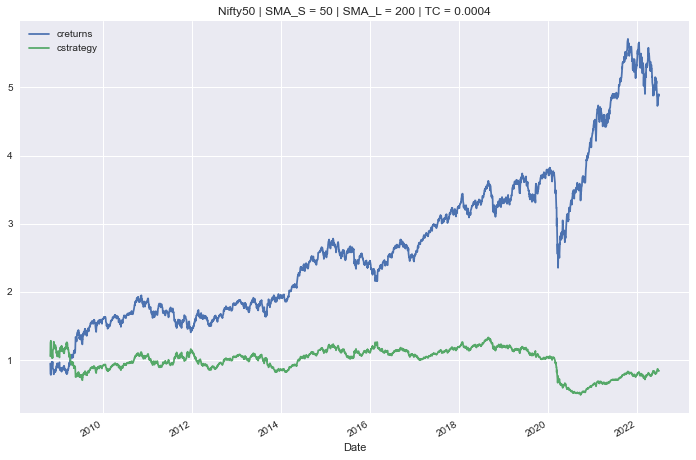

In [7]:
tester.plot_results()

In [8]:
tester.optimize_parameters((10, 50, 1), (51, 200, 1))

(array([10., 87.]), 5.213497)

In [9]:
tester.test_strategy()

(5.213497, 2.108188)

In [10]:
tester.results

,price,returns,SMA_S,SMA_L,position,strategy,trades,creturns,cstrategy
Date,,,,,,,,,
2008-05-09,4982.600098,-0.019694,5132.765039,5174.006886,-1,0.019694,0.0,0.980499,1.019889
2008-05-12,5012.649902,0.006013,5122.860010,5160.595967,-1,-0.006013,0.0,0.986412,1.013775
2008-05-13,4957.799805,-0.011003,5109.675000,5146.564358,-1,0.011003,0.0,0.975618,1.024991
2008-05-14,5011.750000,0.010823,5091.300000,5132.052291,-1,-0.010823,0.0,0.986235,1.013957
2008-05-15,5115.250000,0.020441,5086.235010,5118.674704,-1,-0.020441,0.0,1.006602,0.993441
...,...,...,...,...,...,...,...,...,...
2022-06-24,15699.250000,0.009125,15551.090039,16663.547795,-1,-0.009125,0.0,3.089370,5.240396
2022-06-27,15832.049805,0.008423,15556.854980,16646.621936,-1,-0.008423,0.0,3.115503,5.196440
2022-06-28,15850.200195,0.001146,15568.665039,16630.229975,-1,-0.001146,0.0,3.119074,5.190489


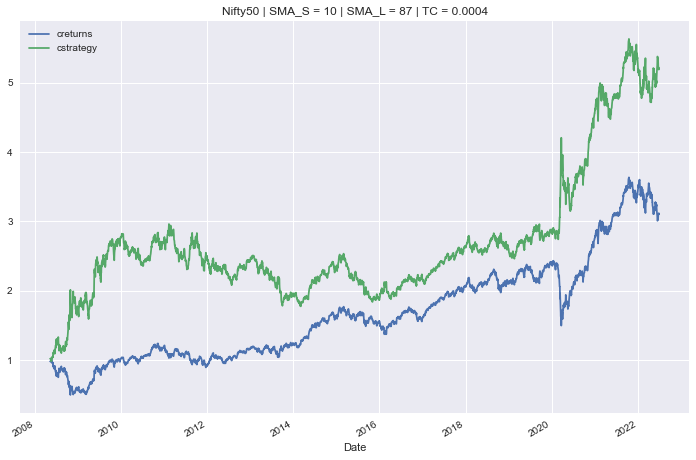

In [11]:
tester.plot_results()